In [66]:
#dealing with data
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

#plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#map
import geopandas as gpd
from shapely.geometry import Point

In [67]:
# Checks for any null values
complaint = pd.read_csv("NYPD_Year_To_Date_Complaints.csv")
complaint.isnull().sum()


BORO_NAME                0
DATE                     0
TIME                     0
CATEGORY                 0
LOCATION OF OCCURANCE    0
OFFENCE DESCRIPTION      0
PREMISE TYPE             0
SUSPECT AGE GROUP        0
SUSPECT_RACE             0
SUSPECT SEX              0
VICTIM AGE GROUP         0
VICTIM RACE              0
VICTIM SEX               0
LATITUDE, LONGITUDE      5
dtype: int64

In [68]:
# Data Cleaning
complaint = complaint.dropna()
complaint.isnull().sum()

pattern = r'\(([-+]?\d+\.\d+), ([-+]?\d+\.\d+)\)'

# Use str.extract to extract the values into new columns
complaint[['latitude', 'longitude']] = complaint['LATITUDE, LONGITUDE'].str.extract(pattern)

complaint['latitude'] = pd.to_numeric(complaint['latitude'])
complaint['longitude'] = pd.to_numeric(complaint['longitude'])

print(complaint["SUSPECT AGE GROUP"].value_counts())
print(complaint["latitude"].quantile([0,0.25,0.5,0.75,1]))
print(complaint["longitude"].quantile([0,0.25,0.5,0.75,1]))

# Removing erroneous data
complaint = complaint.loc[~((complaint["SUSPECT AGE GROUP"] == "1022") |
                                     (complaint["SUSPECT AGE GROUP"] == "1023") |
                                     (complaint["SUSPECT AGE GROUP"] == "2023") |
                                     (complaint["SUSPECT AGE GROUP"] == "942") |
                                     (complaint["SUSPECT AGE GROUP"] == "938") |
                                     (complaint["SUSPECT AGE GROUP"] == "929") |
                                     (complaint["SUSPECT AGE GROUP"] == "-963") |
                                     (complaint["SUSPECT AGE GROUP"] == "-5") |
                                     (complaint["SUSPECT AGE GROUP"] == "-953") |
                                     (complaint["SUSPECT AGE GROUP"] == "925") |
                                     (complaint["latitude"] == 0.0))]
borough_mapping = {
    'BRONX': 'Bronx',
    'MANHATTAN': 'Manhattan',
    'STATEN ISLAND': 'Staten Island',
    'QUEENS': 'Queens',
    'BROOKLYN': 'Brooklyn'
}
complaint["BORO_NAME"] = complaint["BORO_NAME"].replace(borough_mapping)
complaint["TIME"] = pd.to_datetime(complaint["TIME"], format="%H:%M:%S")

print(complaint["SUSPECT AGE GROUP"].value_counts())
print(complaint["latitude"].quantile([0,0.25,0.5,0.75,1]))

SUSPECT AGE GROUP
UNKNOWN    103840
25-44       76342
(null)      36491
45-64       26158
18-24       19943
<18          6079
65           2803
1022           25
1023           15
2023            9
942             1
938             1
929             1
-963            1
-5              1
-953            1
925             1
Name: count, dtype: int64
0.00     0.000000
0.25    40.675333
0.50    40.734681
0.75    40.811938
1.00    40.912714
Name: latitude, dtype: float64
0.00   -74.254377
0.25   -73.973131
0.50   -73.924942
0.75   -73.878351
1.00     0.000000
Name: longitude, dtype: float64
SUSPECT AGE GROUP
UNKNOWN    103840
25-44       76341
(null)      36491
45-64       26158
18-24       19943
<18          6079
65           2803
Name: count, dtype: int64
0.00    40.499315
0.25    40.675332
0.50    40.734681
0.75    40.811938
1.00    40.912714
Name: latitude, dtype: float64


CATEGORY
MISDEMEANOR    138742
FELONY          90434
VIOLATION       42479
Name: count, dtype: int64


CATEGORY
MISDEMEANOR    51.072868
FELONY         33.290019
VIOLATION      15.637113
Name: proportion, dtype: float64

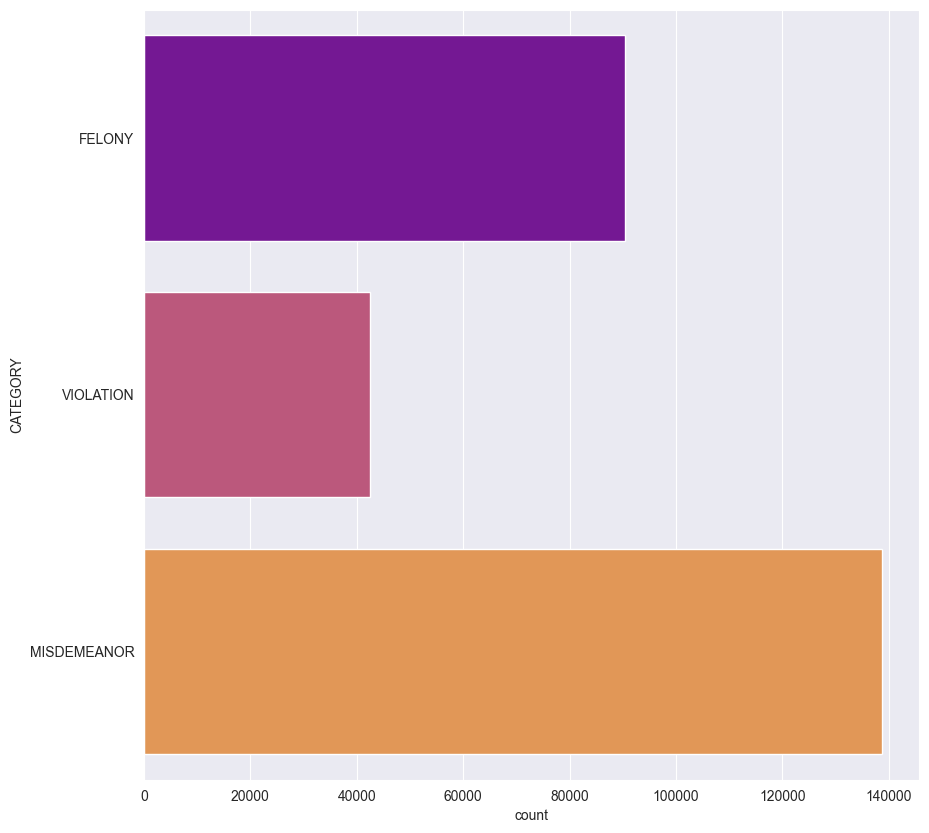

In [69]:
ax = sns.countplot(data=complaint["CATEGORY"], palette="plasma", legend=False)
fig = plt.gcf()
fig.set_size_inches(10,10)
print(complaint["CATEGORY"].value_counts())
complaint["CATEGORY"].value_counts(normalize=True) * 100

Data shows that misdemeanor is the leading types of complaints, followed by felony and violation. In fact, misdemeanor is 51% of all complaints. 


BORO_NAME
Brooklyn         76370
Manhattan        64221
Queens           59574
Bronx            58905
Staten Island    12154
(null)             431
Name: count, dtype: int64


BORO_NAME
Brooklyn         28.112864
Manhattan        23.640647
Queens           21.930022
Bronx            21.683753
Staten Island     4.474057
(null)            0.158657
Name: proportion, dtype: float64

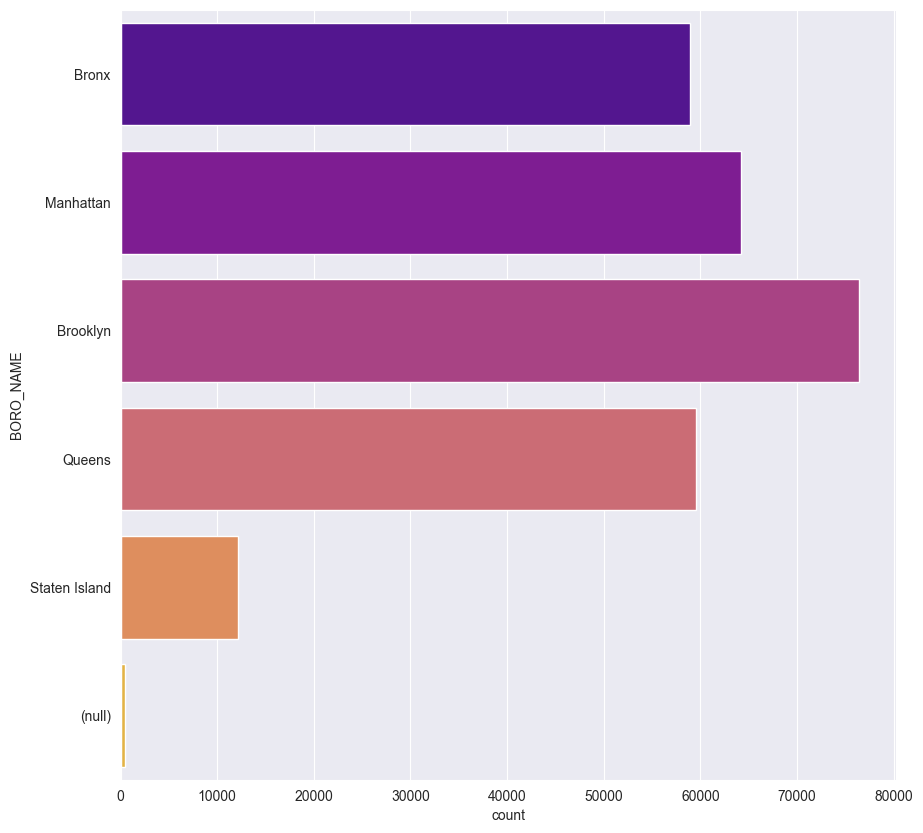

In [70]:
ax = sns.countplot(data=complaint["BORO_NAME"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
print(complaint["BORO_NAME"].value_counts())
complaint["BORO_NAME"].value_counts(normalize=True) * 100

It also seems that Brooklyn has the highest complaint rate, contributing to 28% of all complaint rate. This is followed by Manhattan which contributes 23% of all com[laint rate. This may be caused by the relatively high population density of Brooklyn and Manhattan which conflates the complaint rate.

To better illustrate this information graphically, we also plot the data as a heatmap on the NY boroughs:

(905464.7390380859, 1075092.8783935546, 112485.76063504723, 280480.4142594267)

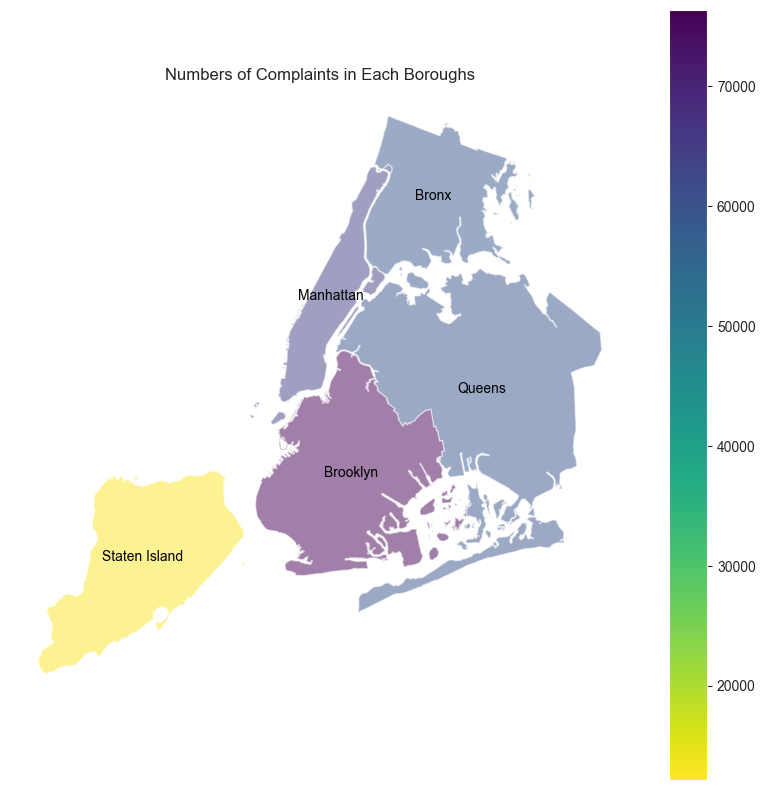

In [71]:
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))

# Count the number of listings by borough
borough_count = complaint.groupby('BORO_NAME').agg('count').reset_index()

nyc.rename(columns={'BoroName':'BORO_NAME'}, inplace=True)
bc_geo = nyc.merge(borough_count, on='BORO_NAME')

# Plot the count by borough into a map
fig, ax = plt.subplots(1,1, figsize=(10,10))
bc_geo.plot(column='CATEGORY', cmap='viridis_r', alpha=.5, ax=ax, legend=True)
bc_geo.apply(lambda x: ax.annotate(text=x.BORO_NAME, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.title(label="Numbers of Complaints in Each Boroughs")
plt.axis('off')

We now plot the individual location of the occurence of complaints on a shp of the New York Boroughs:

(-74.28337047811618, -73.67222994890716, 40.475164048167294, 40.93650271594721)

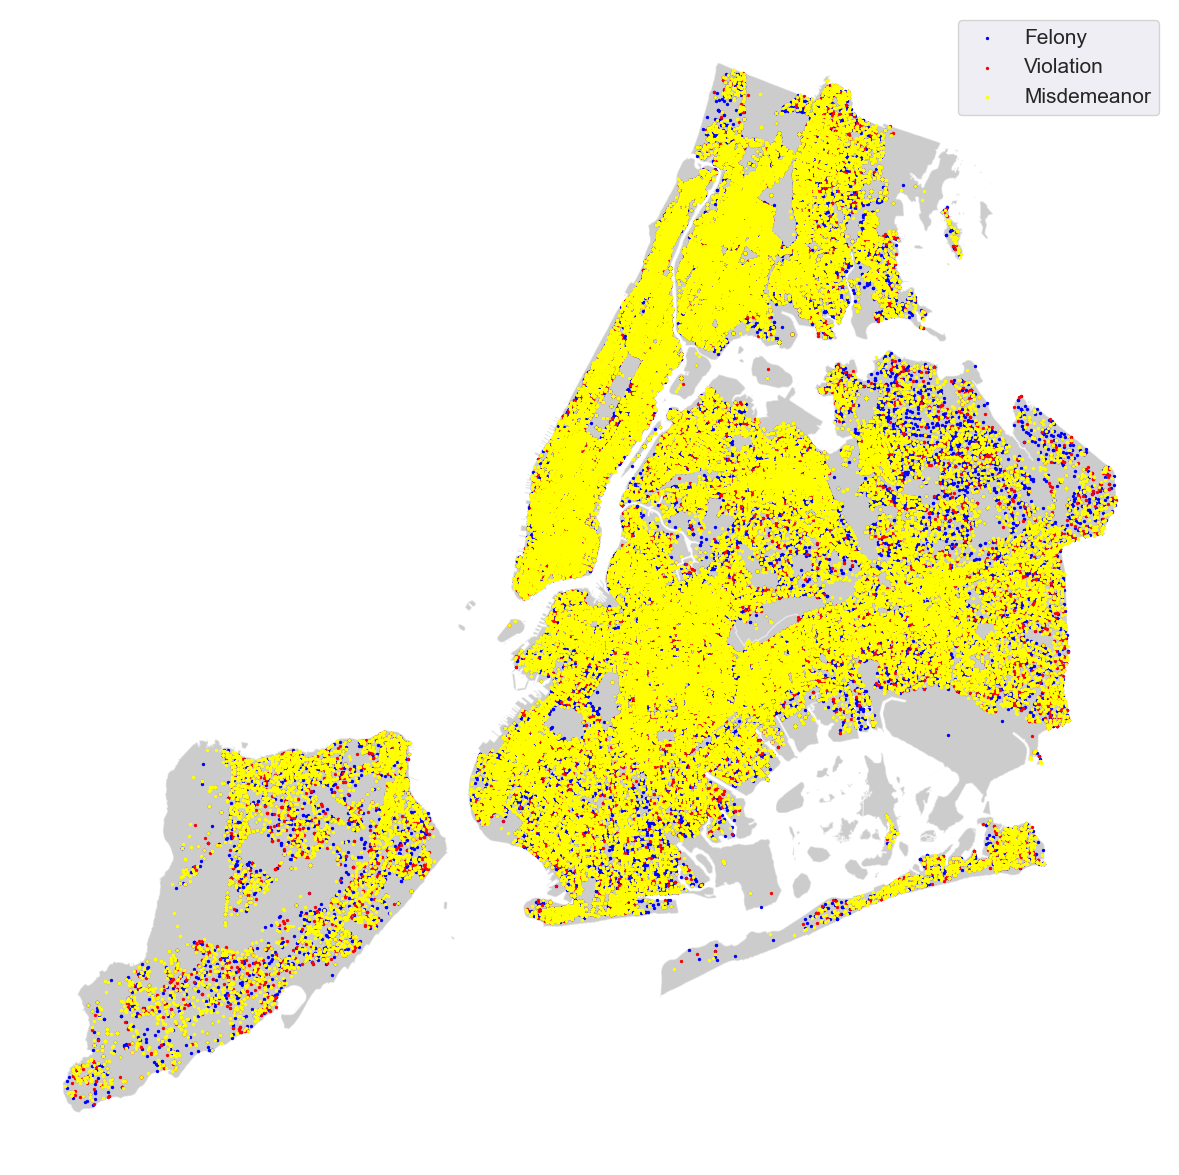

In [72]:
street_map = gpd.read_file("NYBoroughs.shp")
crs = {'init':'epsg:4326'}  

geometry = [Point(xy) for xy in zip(complaint['longitude'], complaint['latitude'])]
geo_df = gpd.GeoDataFrame(complaint, crs=crs, geometry=geometry)
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')

geo_df[geo_df['CATEGORY'] == "FELONY"].plot(ax=ax,
                                       markersize=2,
                                       color='blue',
                                       marker='o',
                                       label='Felony')
geo_df[geo_df['CATEGORY'] == "VIOLATION"].plot(ax=ax,
                                       markersize=2,
                                       color='red',
                                       marker='o',
                                       label='Violation')
geo_df[geo_df['CATEGORY'] == "MISDEMEANOR"].plot(ax=ax,
                                               markersize=2,
                                               color='yellow',
                                               marker='o',
                                               label='Misdemeanor')
plt.legend(prop={'size':15})
plt.axis("off")

Due to the sheer density of misdemeanor, an illustration that only consists of felony and violation is also included below.

(-74.28337047811618, -73.67222994890716, 40.475164048167294, 40.93650271594721)

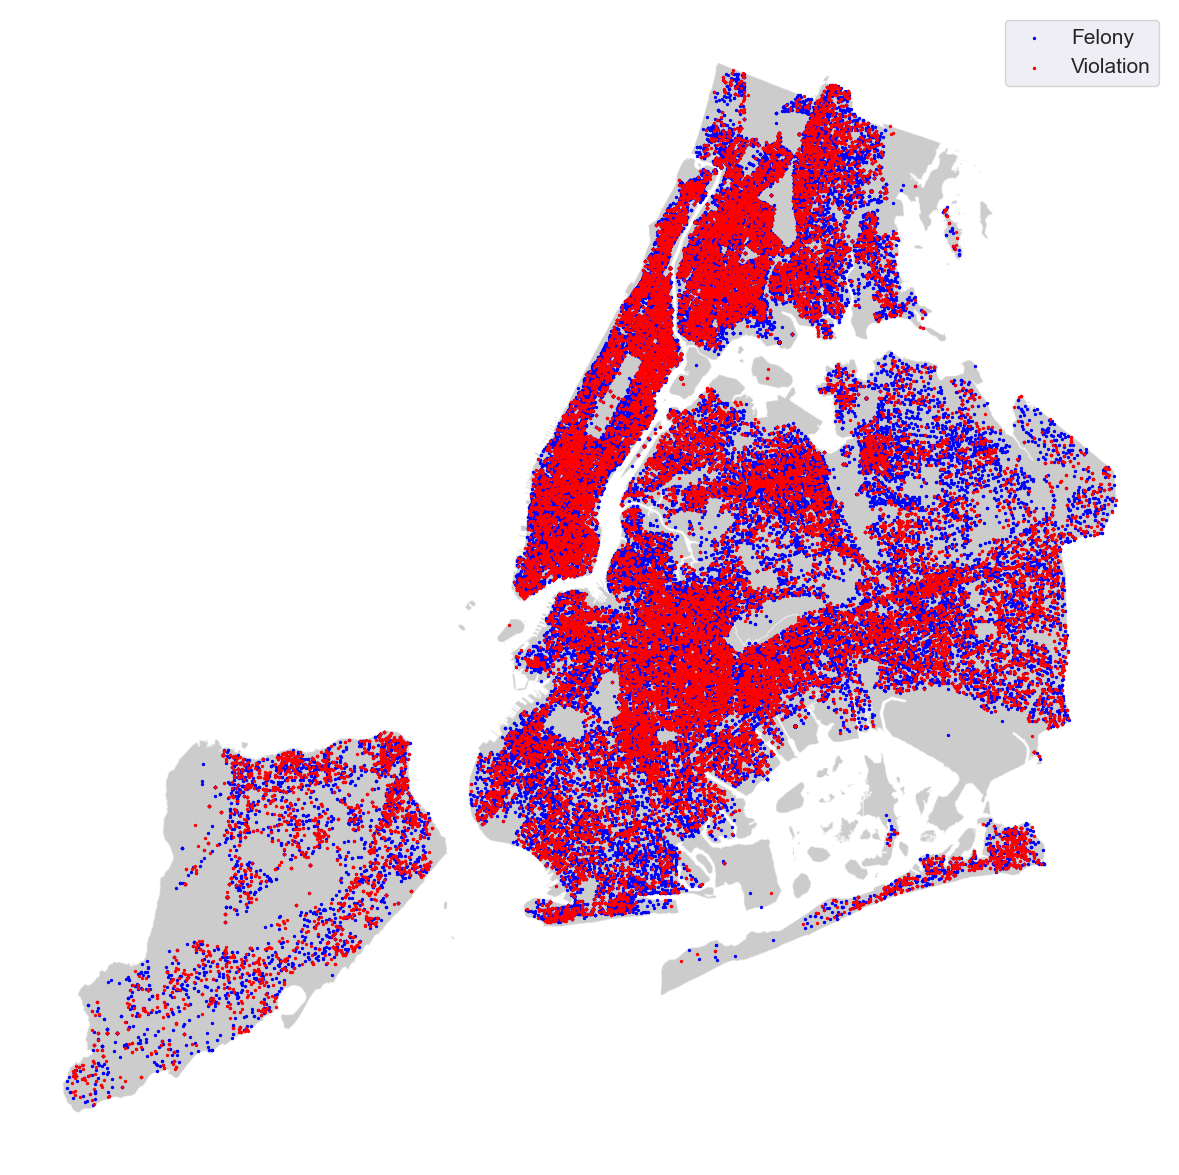

In [73]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['CATEGORY'] == "FELONY"].plot(ax=ax,
                                            markersize=2,
                                            color='blue',
                                            marker='o',
                                            label='Felony')
geo_df[geo_df['CATEGORY'] == "VIOLATION"].plot(ax=ax,
                                               markersize=2,
                                               color='red',
                                               marker='o',
                                               label='Violation')
plt.legend(prop={'size':15})
plt.axis("off")

From the plot of the locations, we see that most complaints are made in populated areas, especially the cities. While there are some sporadic dots somewhere, most of them are densely concentrated in some areas. In fact, the location of the occurrences of complaints generally overlaps.

While the locations of where complaints occur is insightful, we can also plot the intervals of when complaints are made.

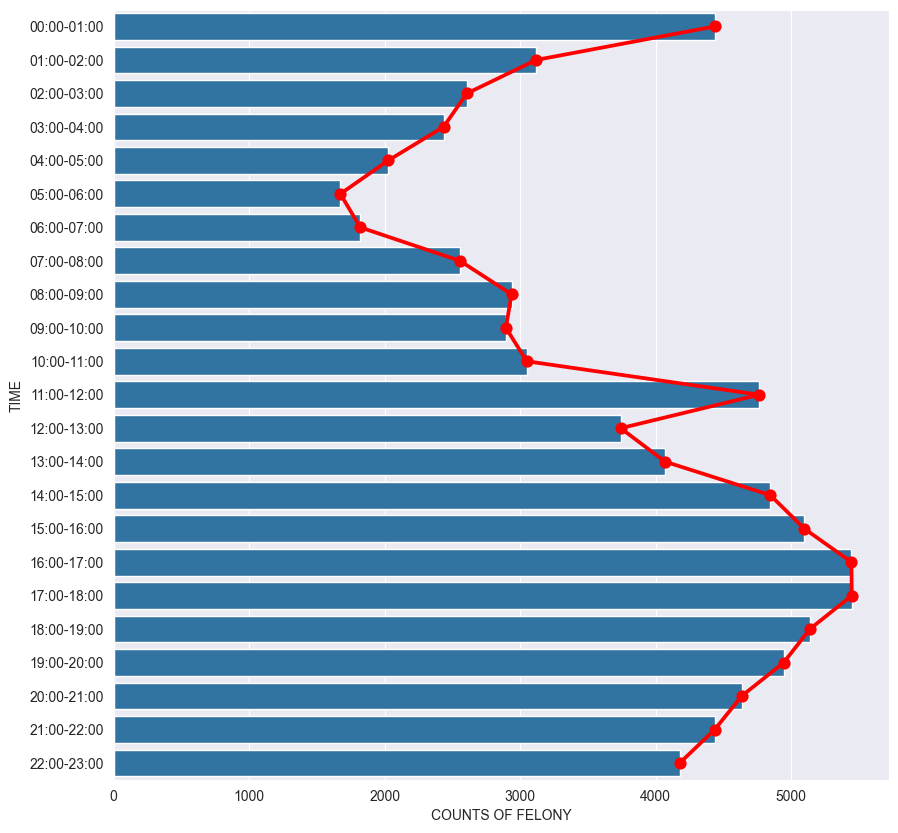

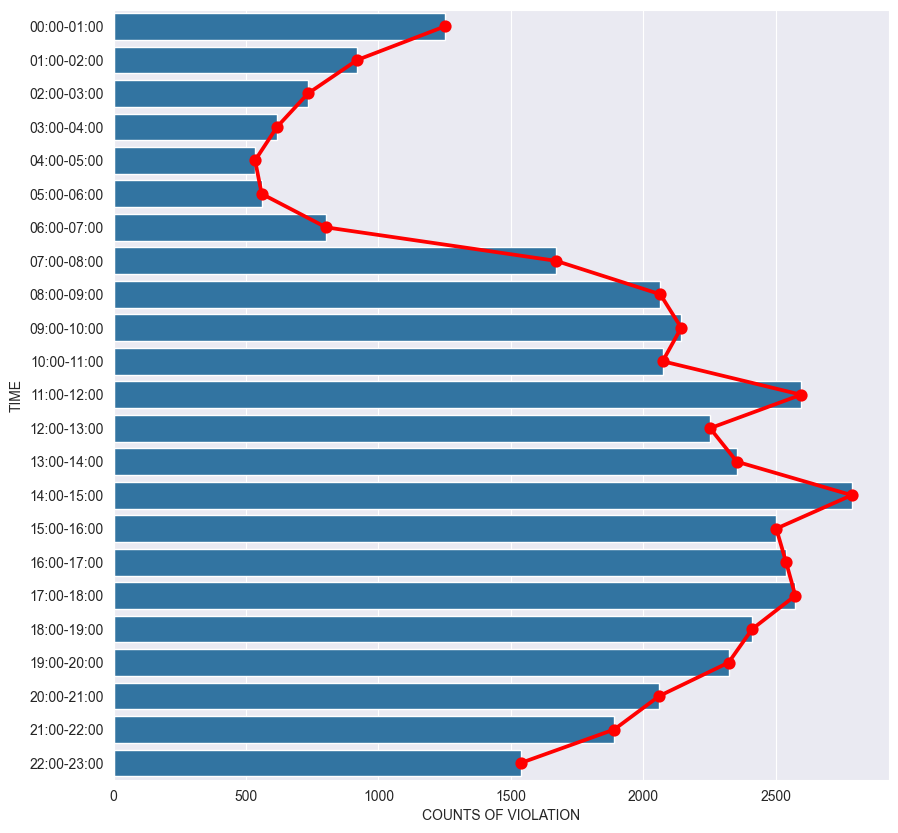

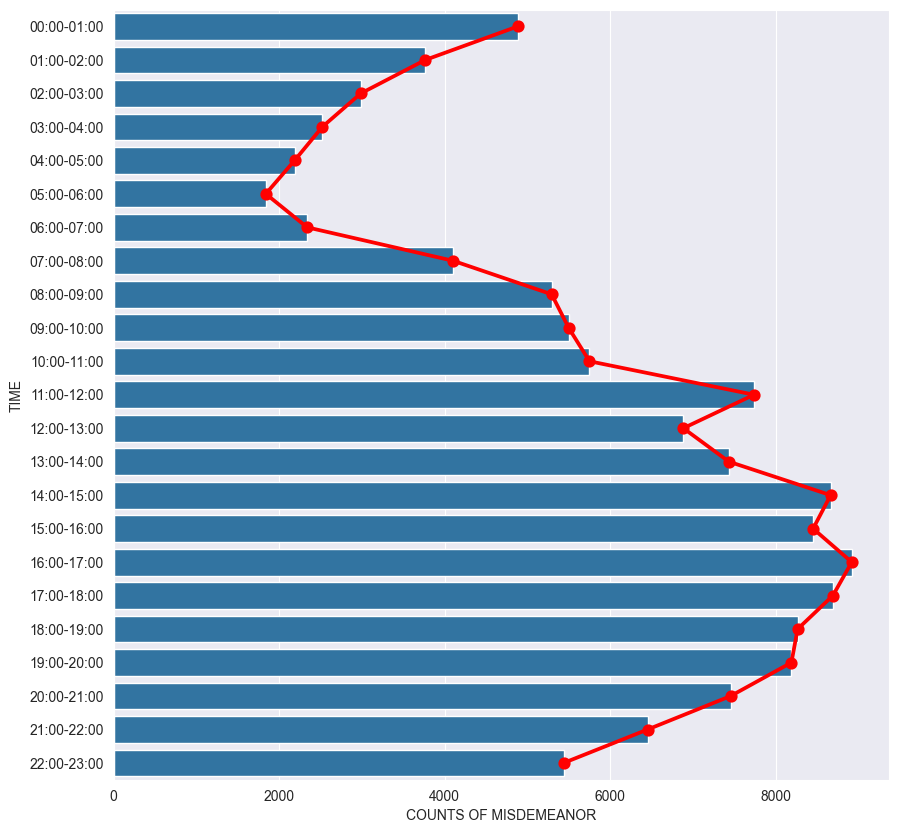

<Figure size 640x480 with 0 Axes>

In [74]:
intervals = pd.date_range(start=complaint['TIME'].min(), end=complaint['TIME'].max(), freq="1H")
df = pd.DataFrame({"INTERVAL": intervals})

time_ranges = []

# Use a for loop to generate the time ranges
for hour in range(0, 23):
    start_time = f"{hour:02d}:00"
    end_time = f"{(hour + 1) % 24:02d}:00"
    time_range = f"{start_time}-{end_time}"
    time_ranges.append(time_range)

# Counting how many counts of different categories of complaints are made in a time interval
for category in complaint['CATEGORY'].unique():
    category_counts = complaint[complaint['CATEGORY'] == category].groupby(pd.cut(complaint['TIME'], bins=df['INTERVAL']), observed=True).size()
    ax = sns.barplot(data=category_counts, orient="h")
    sns.pointplot(data=category_counts, orient="h", color="red")
    
    fig = plt.gcf()
    ax.set_yticks(range(0,23))
    ax.set_yticklabels(time_ranges)
    ax.set_xlabel("COUNTS OF " + category)
    plt.figure()
    fig.set_size_inches(10,10)

plt.show()

Looking at the overall trend of all three plots, we see that complaint rates dropped to its lowest around daybreak (5:00-6:00) but peaks around afternoon(14:00-17:00). This perhaps indicate the need of more patrols and presence of law enforcement around this period.

We now complete the analysis with some simple bar graphs:

BORO_NAME
Brooklyn         25560
Manhattan        21684
Bronx            20254
Queens           19622
Staten Island     3302
(null)              12
Name: count, dtype: int64

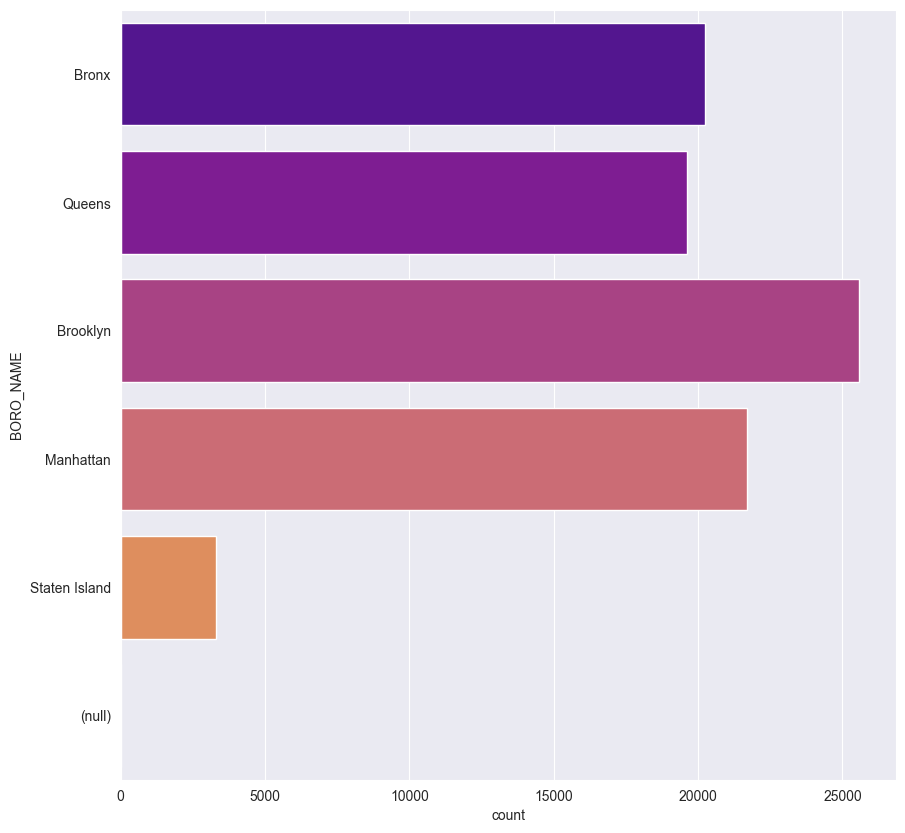

In [76]:
ax = sns.countplot(data=complaint.query('CATEGORY== "FELONY"')["BORO_NAME"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
complaint.query('CATEGORY== "FELONY"')["BORO_NAME"].value_counts()

SUSPECT_RACE
BLACK                             81939
UNKNOWN                           72239
WHITE HISPANIC                    39355
(null)                            36491
WHITE                             19895
BLACK HISPANIC                    12761
ASIAN / PACIFIC ISLANDER           8436
AMERICAN INDIAN/ALASKAN NATIVE      539
Name: count, dtype: int64

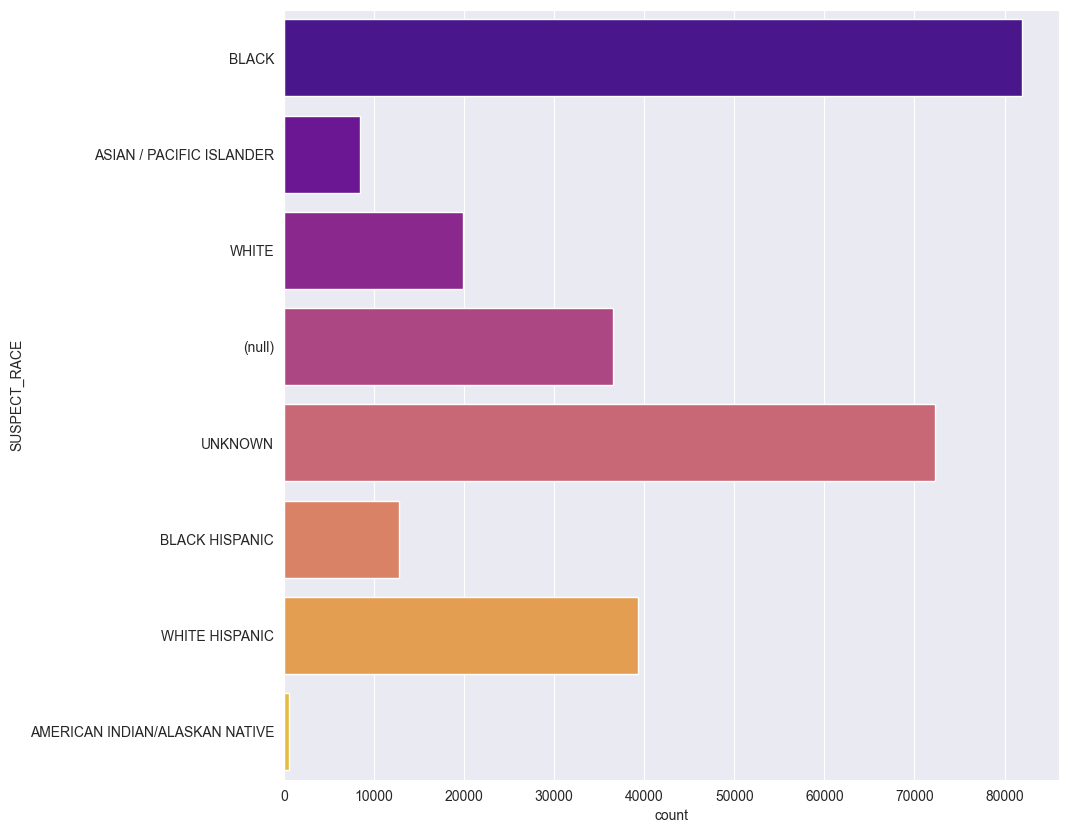

In [77]:
ax = sns.countplot(data=complaint["SUSPECT_RACE"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
complaint["SUSPECT_RACE"].value_counts()

OFFENCE DESCRIPTION
PETIT LARCENY                     54103
HARRASSMENT 2                     41560
ASSAULT 3 & RELATED OFFENSES      28414
GRAND LARCENY                     24351
CRIMINAL MISCHIEF & RELATED OF    20954
                                  ...  
KIDNAPPING                            5
INTOXICATED/IMPAIRED DRIVING          4
FELONY SEX CRIMES                     3
DISRUPTION OF A RELIGIOUS SERV        2
OTHER TRAFFIC INFRACTION              1
Name: count, Length: 61, dtype: int64


OFFENCE DESCRIPTION
PETIT LARCENY                     19.916070
HARRASSMENT 2                     15.298817
ASSAULT 3 & RELATED OFFENSES      10.459590
GRAND LARCENY                      8.963943
CRIMINAL MISCHIEF & RELATED OF     7.713460
                                    ...    
KIDNAPPING                         0.001841
INTOXICATED/IMPAIRED DRIVING       0.001472
FELONY SEX CRIMES                  0.001104
DISRUPTION OF A RELIGIOUS SERV     0.000736
OTHER TRAFFIC INFRACTION           0.000368
Name: proportion, Length: 61, dtype: float64

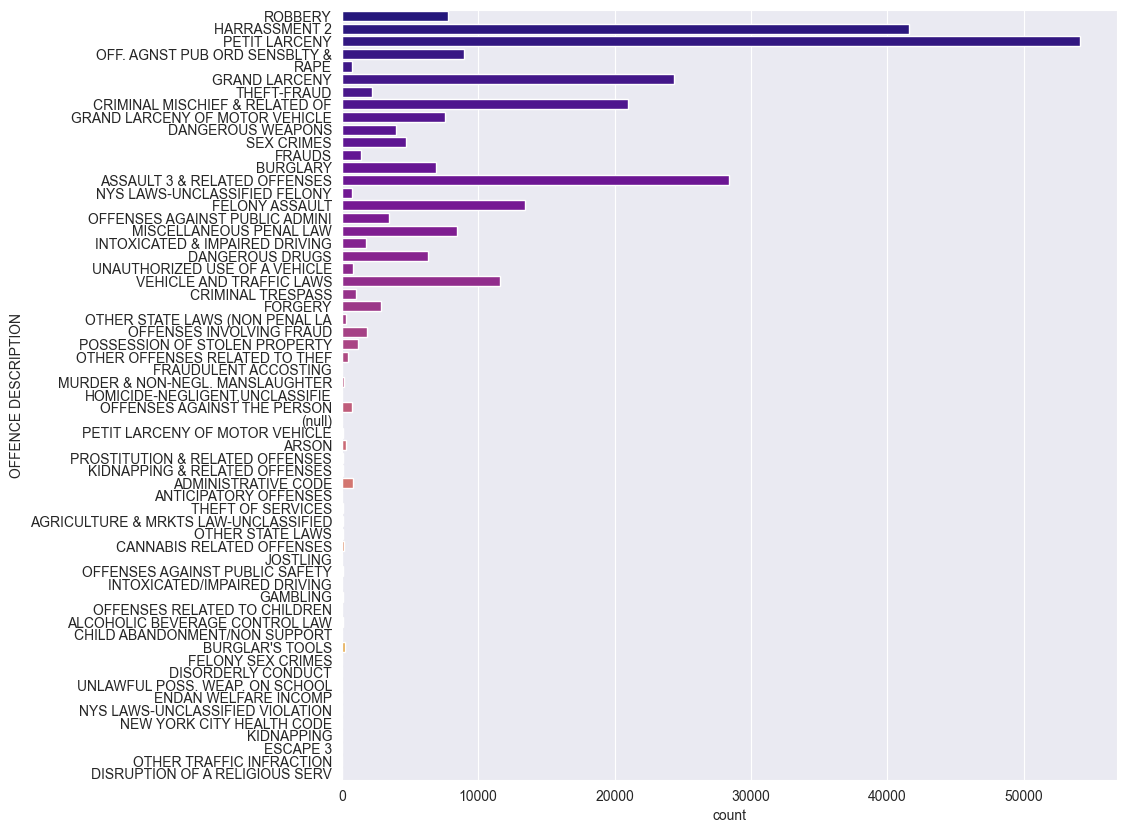

In [92]:
ax = sns.countplot(data=complaint["OFFENCE DESCRIPTION"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
print(complaint["OFFENCE DESCRIPTION"].value_counts())
complaint["OFFENCE DESCRIPTION"].value_counts(normalize=True) * 100

It seems that most of the complaints made are related to some forms of harassment or petit larceny.

SUSPECT AGE GROUP
UNKNOWN    103840
25-44       76341
(null)      36491
45-64       26158
18-24       19943
<18          6079
65           2803
Name: count, dtype: int64


SUSPECT AGE GROUP
UNKNOWN    38.224954
25-44      28.102188
(null)     13.432847
45-64       9.629125
18-24       7.341297
<18         2.237765
65          1.031823
Name: proportion, dtype: float64

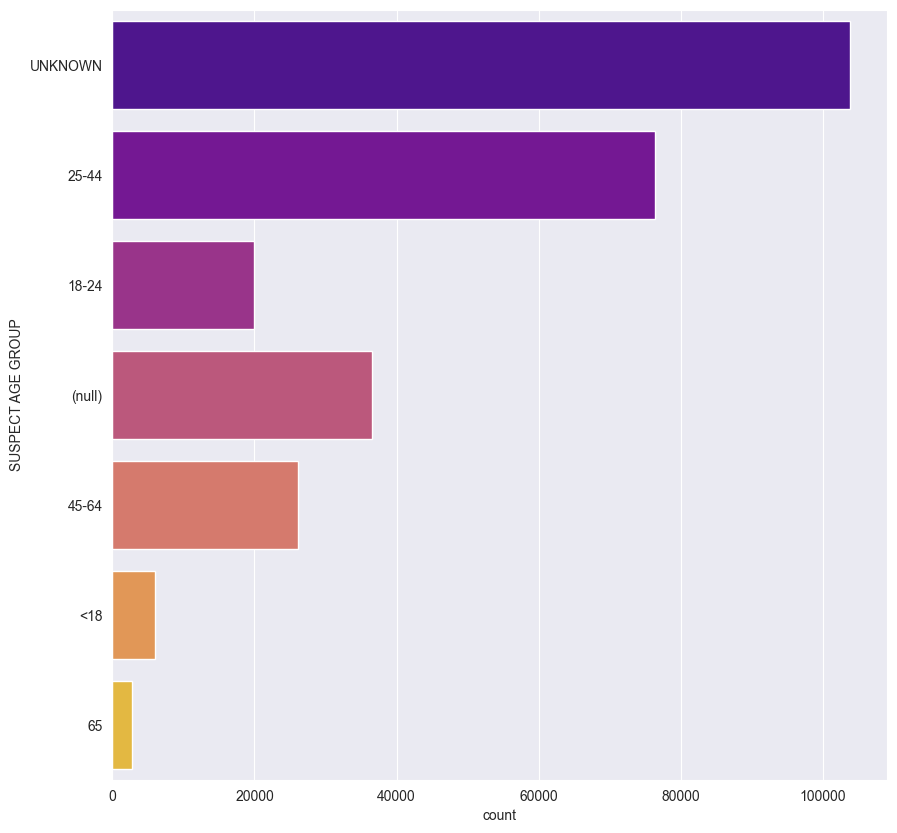

In [89]:
ax = sns.countplot(data=complaint["SUSPECT AGE GROUP"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
print(complaint["SUSPECT AGE GROUP"].value_counts())
complaint["SUSPECT AGE GROUP"].value_counts(normalize=True) * 100

It seems that most of the suspects have unknown age group. This could be due to 1) bad documentation 2) Uncaught suspects 3) Suspect has no valid ID. Regardless, the data shows that most complaints are made against adults within the range of 25-44. We now further analyze the group of (25-44):

SUSPECT SEX
M    58238
F    15602
U     2501
Name: count, dtype: int64
SUSPECT SEX
M    76.286661
F    20.437249
U     3.276090
Name: proportion, dtype: float64


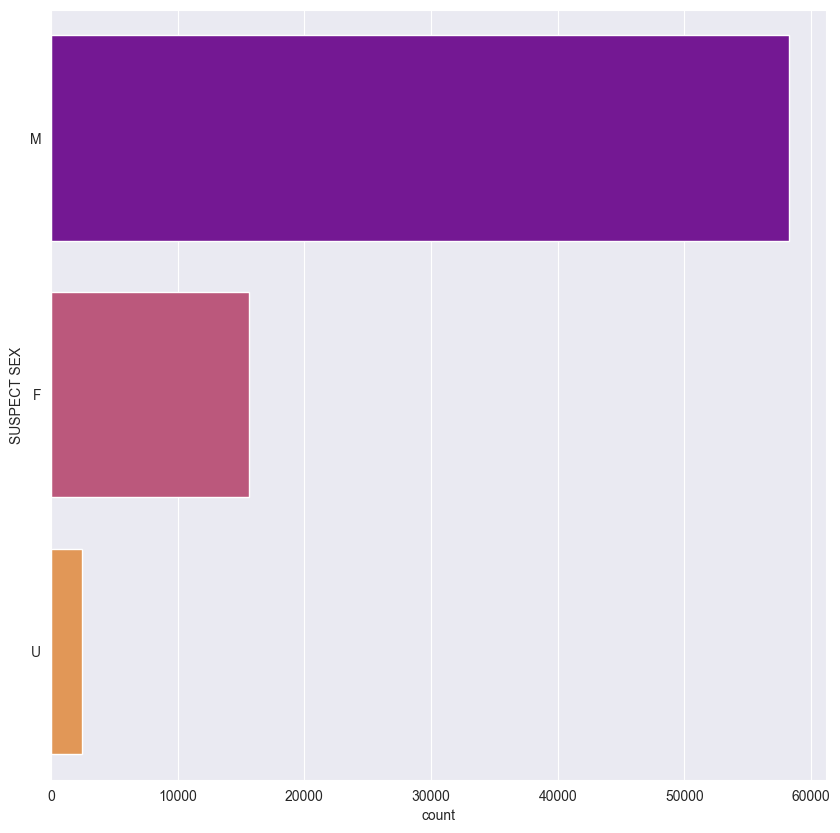

In [88]:
ax = sns.countplot(data=complaint.query('`SUSPECT AGE GROUP` == "25-44"')["SUSPECT SEX"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
print(complaint.query('`SUSPECT AGE GROUP` == "25-44"')["SUSPECT SEX"].value_counts())
print(complaint.query('`SUSPECT AGE GROUP` == "25-44"')["SUSPECT SEX"].value_counts(normalize=True) * 100)

It seems that most of the suspects (76.3%) within the age range of 25-44 is male. 

OFFENCE DESCRIPTION
HARRASSMENT 2                           12442
ASSAULT 3 & RELATED OFFENSES            11486
PETIT LARCENY                            8646
FELONY ASSAULT                           5950
MISCELLANEOUS PENAL LAW                  4441
VEHICLE AND TRAFFIC LAWS                 4134
CRIMINAL MISCHIEF & RELATED OF           3906
OFF. AGNST PUB ORD SENSBLTY &            3258
DANGEROUS DRUGS                          3179
GRAND LARCENY                            2327
ROBBERY                                  2118
OFFENSES AGAINST PUBLIC ADMINI           2067
SEX CRIMES                               1941
DANGEROUS WEAPONS                        1867
FORGERY                                  1510
BURGLARY                                 1090
INTOXICATED & IMPAIRED DRIVING           1043
OFFENSES INVOLVING FRAUD                  960
POSSESSION OF STOLEN PROPERTY             552
NYS LAWS-UNCLASSIFIED FELONY              373
CRIMINAL TRESPASS                         366
UNAUTHORIZED U

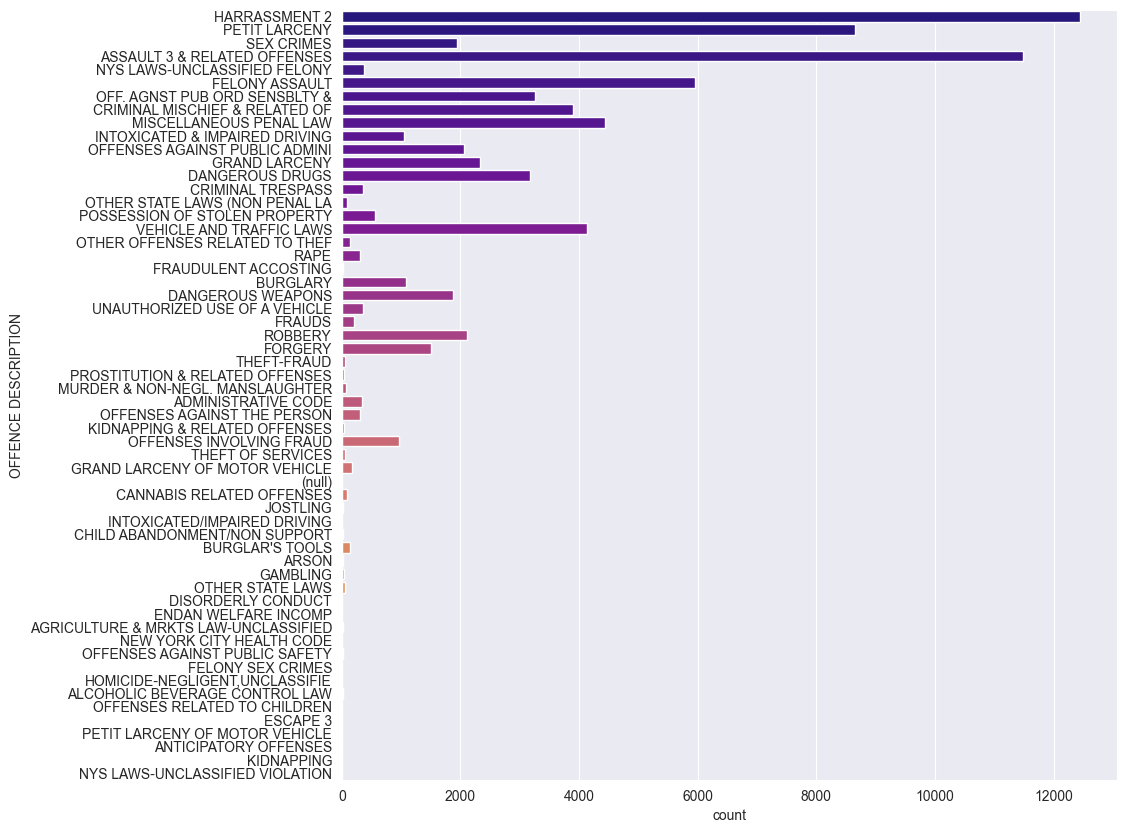

In [90]:
ax = sns.countplot(data=complaint.query('`SUSPECT AGE GROUP` == "25-44"')["OFFENCE DESCRIPTION"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
print(complaint.query('`SUSPECT AGE GROUP` == "25-44"')["OFFENCE DESCRIPTION"].value_counts())
print(complaint.query('`SUSPECT AGE GROUP` == "25-44"')["OFFENCE DESCRIPTION"].value_counts(normalize=True) * 100)

Majority of the complaints made against the age group is for harassment and assault.

CATEGORY
MISDEMEANOR    39521
FELONY         23975
VIOLATION      12845
Name: count, dtype: int64
CATEGORY
MISDEMEANOR    51.769036
FELONY         31.405143
VIOLATION      16.825821
Name: proportion, dtype: float64


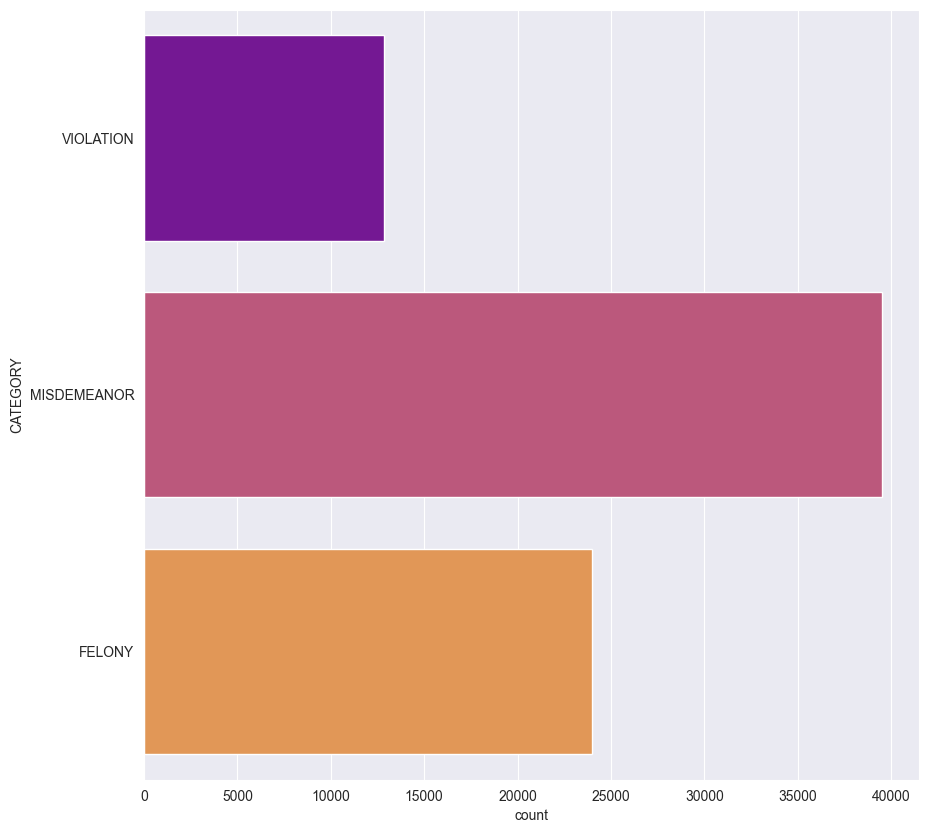

In [93]:
ax = sns.countplot(data=complaint.query('`SUSPECT AGE GROUP` == "25-44"')["CATEGORY"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
print(complaint.query('`SUSPECT AGE GROUP` == "25-44"')["CATEGORY"].value_counts())
print(complaint.query('`SUSPECT AGE GROUP` == "25-44"')["CATEGORY"].value_counts(normalize=True) * 100)

52% of all complaints made against the age group is misdemeanor.  

VICTIM SEX
F    103051
M     92618
D     43982
E     29976
L      2028
Name: count, dtype: int64


VICTIM SEX
F    37.934513
M    34.093979
D    16.190389
E    11.034584
L     0.746535
Name: proportion, dtype: float64

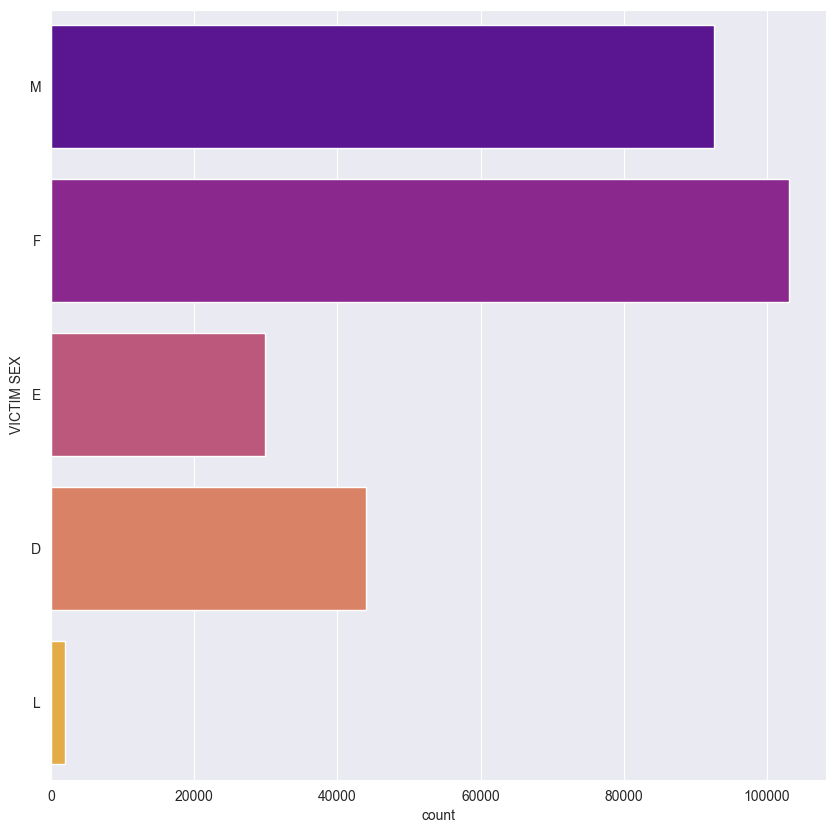

In [101]:
ax = sns.countplot(data=complaint["VICTIM SEX"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10, 10)
print(complaint["VICTIM SEX"].value_counts())
complaint["VICTIM SEX"].value_counts(normalize=True) * 100

It seems that a majority of the complaints are made by females (37%). However, complaints by males is (34%) indicating that females are only slightly targeted more often and that in a huge population, both males and females are almost equally targeted against.

SUSPECT SEX
M         48892
U         23625
F         18394
(null)    12140
Name: count, dtype: int64


SUSPECT SEX
M         47.444469
U         22.925542
F         17.849414
(null)    11.780575
Name: proportion, dtype: float64

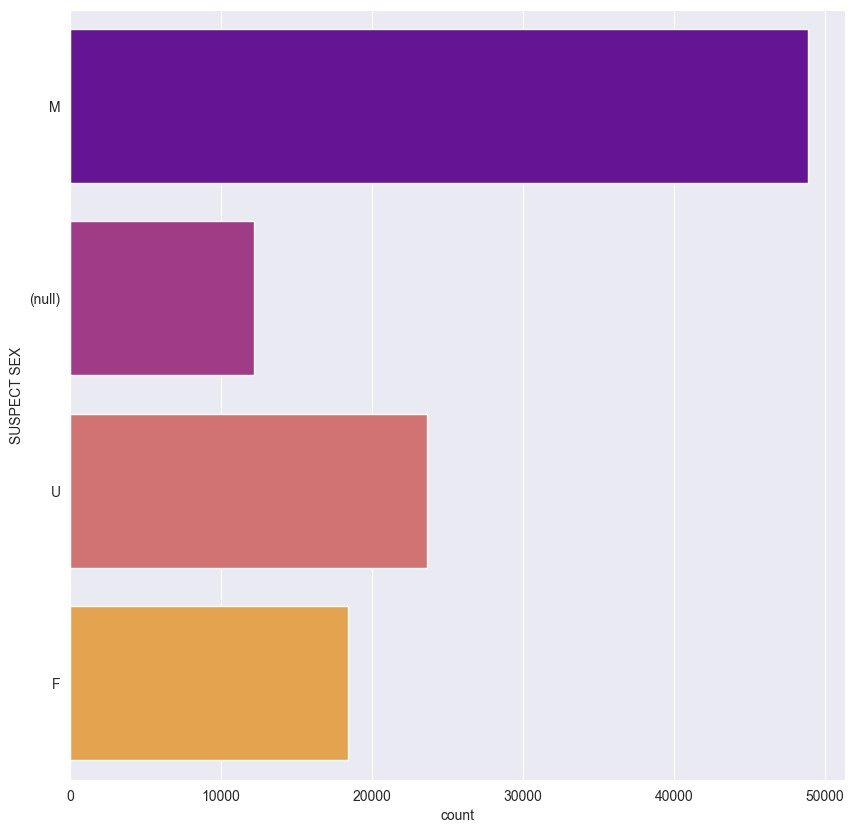

In [100]:
ax = sns.countplot(data=complaint.query('`VICTIM SEX` == "F"')["SUSPECT SEX"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10, 10)
print(complaint.query('`VICTIM SEX` == "F"')["SUSPECT SEX"].value_counts())
complaint.query('`VICTIM SEX` == "F"')["SUSPECT SEX"].value_counts(normalize=True) * 100

However, data also indicates that females are more often targeted by males. In fact, 47% of complaints made by women are against males. 

SUSPECT SEX
M         38461
U         28046
(null)    14436
F         11675
Name: count, dtype: int64


SUSPECT SEX
M         41.526485
U         30.281371
(null)    15.586603
F         12.605541
Name: proportion, dtype: float64

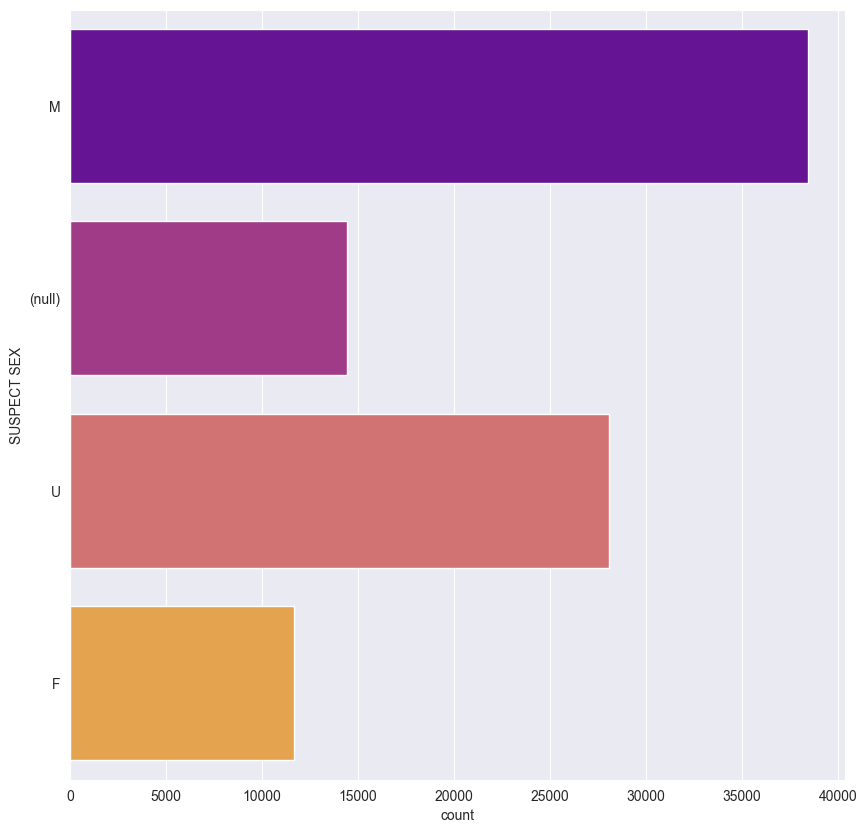

In [99]:
ax = sns.countplot(data=complaint.query('`VICTIM SEX` == "M"')["SUSPECT SEX"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10, 10)
print(complaint.query('`VICTIM SEX` == "M"')["SUSPECT SEX"].value_counts())
complaint.query('`VICTIM SEX` == "M"')["SUSPECT SEX"].value_counts(normalize=True) * 100

Data also indicates that 41% of complaints made by male is also made against male.